In [31]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import re
from difflib import get_close_matches


In [ ]:
train = pd.read_csv('./files/train.csv')
test = pd.read_csv('./files/test.csv')
submission = pd.read_csv('./files/submission_sample.csv')


In [11]:
train.describe()

,Total Working Experience,Expected Benefit Botom,Expected Benefit Up,Estimate Bottom,Estimate Up
count,1160.000000,1.160000e+03,1.160000e+03,1.160000e+03,1.160000e+03
mean,3.126724,4.212931e+05,1.681897e+05,7.602155e+06,1.182543e+07
std,2.830618,2.148195e+06,1.413114e+06,3.705119e+06,6.002688e+06
min,0.000000,0.000000e+00,0.000000e+00,2.500000e+06,4.000000e+06
25%,1.000000,0.000000e+00,0.000000e+00,5.000000e+06,8.000000e+06
50%,3.000000,0.000000e+00,0.000000e+00,8.000000e+06,1.200000e+07
75%,4.000000,0.000000e+00,0.000000e+00,8.000000e+06,1.200000e+07
max,19.000000,2.150000e+07,2.300000e+07,3.500000e+07,5.500000e+07


In [ ]:
train['ID'].is_unique

True

No Data duplicates, nice

In [17]:
#Seperating Numerical and Categorical Columns
num_cols = [
    "Total Working Experience",
    "Expected Benefit Botom",
    "Expected Benefit Up",
    "Estimate Bottom",
    "Estimate Up",
]

cat_cols = [
    "ID",
    "Current Position",
    "Targeted Position",
    "Candidate Level",
    "Domisili",
    "Education 1",
    "Education 2",
    "Education 3",
    "Notice Period",
    "Tech Stack",
    "Certification",
]

Missing Values in Numerical Columns:
                          Missing Values  Missing Percentage
Total Working Experience               0                 0.0
Expected Benefit Botom                 0                 0.0
Expected Benefit Up                    0                 0.0
Estimate Bottom                        0                 0.0
Estimate Up                            0                 0.0


Missing Values in Categorical Columns:
                   Missing Values  Missing Percentage
Notice Period                1103           95.086207
Education 3                  1031           88.879310
Targeted Position             958           82.586207
Education 2                   629           54.224138
Certification                 359           30.948276
Current Position              141           12.155172
Domisili                       99            8.534483
Education 1                    18            1.551724
Tech Stack                      5            0.431034
ID              

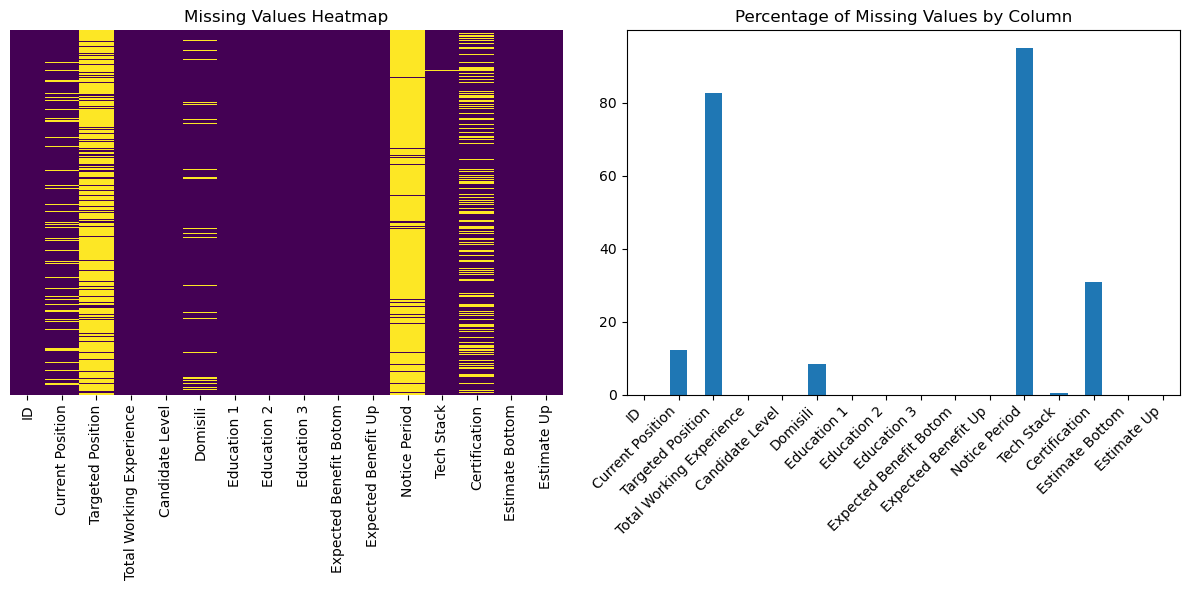

In [ ]:
# Check missing values percentage by column
def check_missing_values(df):
    missing = df.isnull().sum()
    missing_pct = (df.isnull().sum() / len(df)) * 100
    missing_df = pd.DataFrame({
        'Missing Values': missing,
        'Missing Percentage': missing_pct
    }).sort_values('Missing Percentage', ascending=False)
    return missing_df

# Separate analysis for numerical and categorical columns
def analyze_missing_by_type(df, num_cols, cat_cols):
    # Numerical columns
    num_missing = check_missing_values(df[num_cols])
    print("Missing Values in Numerical Columns:")
    print(num_missing)
    print("\n")
    
    # Categorical columns  
    cat_missing = check_missing_values(df[cat_cols])
    print("Missing Values in Categorical Columns:")
    print(cat_missing)


def analyze_missing_patterns(df):
    # Cross tabulate missingness with Candidate Level
    level_missing = pd.crosstab(df['Candidate Level'].isnull(), 
                               df['Targeted Position'].isnull(),
                               normalize='index')
    print("Missing Pattern Analysis - Candidate Level vs Targeted Position:")
    print(level_missing)


def handle_education_missing(df):
    edu_cols = ['Education 1', 'Education 2', 'Education 3']
    df[edu_cols] = df[edu_cols].fillna('None')
    return df

def plot_missing_patterns(df):
    plt.figure(figsize=(12,6))
    
    # Heatmap
    plt.subplot(1,2,1)
    sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis')
    plt.title('Missing Values Heatmap')
    
    # Bar plot
    plt.subplot(1,2,2)
    missing_pct = df.isnull().mean() * 100
    missing_pct.plot(kind='bar')
    plt.title('Percentage of Missing Values by Column')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

analyze_missing_by_type(train, num_cols, cat_cols)
analyze_missing_patterns(train)
train = handle_education_missing(train)
plot_missing_patterns(train)

In [19]:
# see existing values in candidate level 
print(train['Candidate Level'].value_counts())

Candidate Level
Mid-Level      652
Junior         429
Senior          60
Entry-Level     18
Fresher          1
Name: count, dtype: int64


In [20]:
# remove domicile column, unlikely to be useful
train = train.drop(columns=['Domisili'])
test = test.drop(columns=['Domisili'])
# mapping candidate level, fresher = entry level (1), junior = 2, mid-level = 3 , senior = 4
level_mapping = {
    'Fresher': 1,
    'Entry Level': 1,
    'Junior': 2,
    'Mid-Level': 3,
    'Senior': 4
}
train['Candidate Level'] = train['Candidate Level'].map(level_mapping)
test['Candidate Level'] = test['Candidate Level'].map(level_mapping)

# Mapping empty current position, target position, notice period to "None" 
train['Current Position'] = train['Current Position'].fillna('None')
train['Targeted Position'] = train['Targeted Position'].fillna('None')
train['Notice Period'] = train['Notice Period'].fillna('None')
test['Current Position'] = test['Current Position'].fillna('None')
test['Targeted Position'] = test['Targeted Position'].fillna('None')
test['Notice Period'] = test['Notice Period'].fillna('None')




In [21]:
train.head()

,ID,Current Position,Targeted Position,Total Working Experience,Candidate Level,Education 1,Education 2,Education 3,Expected Benefit Botom,Expected Benefit Up,Notice Period,Tech Stack,Certification,Estimate Bottom,Estimate Up
0,SKU-WENU1319,Web Developer,None,2,2.0,UNIVERSITAS TERBUKA (2023-2027)\nBachelor of S...,SMK Negeri 2 Tasikmalaya (2019 - 2023)\nSistem...,None,0,0,None,"HTML ,CSS ,Javascript(ReactJs) ,Jquery ,Ajax ,...","[""Junior Web Developer, Digitalent Scholarship...",6000000.0,9000000.0
1,SKU-FUNU1303,Full Stack Developer,None,1,3.0,Padjadjaran University 2017-2021,None,None,0,0,None,"Laravel, Phalcon, Python, Django, Next.Js, Tai...","[""Google Data Analytics, Coursera Jul 2023"",""L...",8000000.0,12000000.0
2,SKU-JUNU1052,Junior Web Developer,None,0,2.0,Universitas Negeri Semarang (2019 - 2024)\nS1 ...,Purwadhika Digital Technology School (2024)\nF...,None,0,0,None,"JavaScript, Prisma ORM, TypeScript, MySQL, Rea...","[""Full-stack Web Developer""]",4000000.0,6000000.0
3,SKU-JANU420,Java Developer,None,0,2.0,"Bachelor's degree, Universitas Pendidikan Indo...",None,None,0,0,None,"React, JavaScript, Mobile Application Software...",[],6000000.0,9000000.0
4,SKU-NUNU1182,None,None,4,3.0,"Ilmu Komputer, Universitas Pendidikan Indonesi...",None,None,0,0,None,"PHP, Python, Java, Javascript, Go, C#, Laravel...",[],8000000.0,12000000.0


In [22]:
# standardizing tech stack and certification columns 
def standardize_tech_cert(df):
    # Standardize Tech Stack
    df['Tech Stack'] = df['Tech Stack'].str.lower().str.replace(r'[^a-z0-9, ]', '', regex=True)
    df['Tech Stack'] = df['Tech Stack'].str.replace(r'\s*,\s*', ',', regex=True)  # Remove spaces around commas
    df['Tech Stack'] = df['Tech Stack'].str.replace(r'\s+', ' ', regex=True).str.strip()  # Remove extra spaces
    
    # Standardize Certification
    df['Certification'] = df['Certification'].str.lower().str.replace(r'[^a-z0-9, ]', '', regex=True)
    df['Certification'] = df['Certification'].str.replace(r'\s*,\s*', ',', regex=True)  # Remove spaces around commas
    df['Certification'] = df['Certification'].str.replace(r'\s+', ' ', regex=True).str.strip()  # Remove extra spaces
    
    return df

train = standardize_tech_cert(train)
test = standardize_tech_cert(test)
train.head()

,ID,Current Position,Targeted Position,Total Working Experience,Candidate Level,Education 1,Education 2,Education 3,Expected Benefit Botom,Expected Benefit Up,Notice Period,Tech Stack,Certification,Estimate Bottom,Estimate Up
0,SKU-WENU1319,Web Developer,None,2,2.0,UNIVERSITAS TERBUKA (2023-2027)\nBachelor of S...,SMK Negeri 2 Tasikmalaya (2019 - 2023)\nSistem...,None,0,0,None,"html,css,javascriptreactjs,jquery,ajax,framewo...","junior web developer,digitalent scholarship,no...",6000000.0,9000000.0
1,SKU-FUNU1303,Full Stack Developer,None,1,3.0,Padjadjaran University 2017-2021,None,None,0,0,None,"laravel,phalcon,python,django,nextjs,tailwind ...","google data analytics,coursera jul 2023,learni...",8000000.0,12000000.0
2,SKU-JUNU1052,Junior Web Developer,None,0,2.0,Universitas Negeri Semarang (2019 - 2024)\nS1 ...,Purwadhika Digital Technology School (2024)\nF...,None,0,0,None,"javascript,prisma orm,typescript,mysql,reactjs...",fullstack web developer,4000000.0,6000000.0
3,SKU-JANU420,Java Developer,None,0,2.0,"Bachelor's degree, Universitas Pendidikan Indo...",None,None,0,0,None,"react,javascript,mobile application software,d...",,6000000.0,9000000.0
4,SKU-NUNU1182,None,None,4,3.0,"Ilmu Komputer, Universitas Pendidikan Indonesi...",None,None,0,0,None,"php,python,java,javascript,go,c,laravel,echo,n...",,8000000.0,12000000.0


In [23]:
#create new columns for tech stack and certification count 
def create_count_columns(df):
    df['Tech Stack Count'] = df['Tech Stack'].apply(lambda x: len(x.split(',')) if pd.notnull(x) and x != 'none' else 0)
    df['Certification Count'] = df['Certification'].apply(lambda x: len(x.split(',')) if pd.notnull(x) and x != 'none' else 0)
    return df

train = create_count_columns(train)
test = create_count_columns(test)
train.head()

,ID,Current Position,Targeted Position,Total Working Experience,Candidate Level,Education 1,Education 2,Education 3,Expected Benefit Botom,Expected Benefit Up,Notice Period,Tech Stack,Certification,Estimate Bottom,Estimate Up,Tech Stack Count,Certification Count
0,SKU-WENU1319,Web Developer,None,2,2.0,UNIVERSITAS TERBUKA (2023-2027)\nBachelor of S...,SMK Negeri 2 Tasikmalaya (2019 - 2023)\nSistem...,None,0,0,None,"html,css,javascriptreactjs,jquery,ajax,framewo...","junior web developer,digitalent scholarship,no...",6000000.0,9000000.0,12,3
1,SKU-FUNU1303,Full Stack Developer,None,1,3.0,Padjadjaran University 2017-2021,None,None,0,0,None,"laravel,phalcon,python,django,nextjs,tailwind ...","google data analytics,coursera jul 2023,learni...",8000000.0,12000000.0,15,14
2,SKU-JUNU1052,Junior Web Developer,None,0,2.0,Universitas Negeri Semarang (2019 - 2024)\nS1 ...,Purwadhika Digital Technology School (2024)\nF...,None,0,0,None,"javascript,prisma orm,typescript,mysql,reactjs...",fullstack web developer,4000000.0,6000000.0,11,1
3,SKU-JANU420,Java Developer,None,0,2.0,"Bachelor's degree, Universitas Pendidikan Indo...",None,None,0,0,None,"react,javascript,mobile application software,d...",,6000000.0,9000000.0,20,1
4,SKU-NUNU1182,None,None,4,3.0,"Ilmu Komputer, Universitas Pendidikan Indonesi...",None,None,0,0,None,"php,python,java,javascript,go,c,laravel,echo,n...",,8000000.0,12000000.0,20,1


In [24]:
# show entire train dataset
train

,ID,Current Position,Targeted Position,Total Working Experience,Candidate Level,Education 1,Education 2,Education 3,Expected Benefit Botom,Expected Benefit Up,Notice Period,Tech Stack,Certification,Estimate Bottom,Estimate Up,Tech Stack Count,Certification Count
0,SKU-WENU1319,Web Developer,None,2,2.0,UNIVERSITAS TERBUKA (2023-2027)\nBachelor of S...,SMK Negeri 2 Tasikmalaya (2019 - 2023)\nSistem...,None,0,0,None,"html,css,javascriptreactjs,jquery,ajax,framewo...","junior web developer,digitalent scholarship,no...",6000000.0,9000000.0,12,3
1,SKU-FUNU1303,Full Stack Developer,None,1,3.0,Padjadjaran University 2017-2021,None,None,0,0,None,"laravel,phalcon,python,django,nextjs,tailwind ...","google data analytics,coursera jul 2023,learni...",8000000.0,12000000.0,15,14
2,SKU-JUNU1052,Junior Web Developer,None,0,2.0,Universitas Negeri Semarang (2019 - 2024)\nS1 ...,Purwadhika Digital Technology School (2024)\nF...,None,0,0,None,"javascript,prisma orm,typescript,mysql,reactjs...",fullstack web developer,4000000.0,6000000.0,11,1
3,SKU-JANU420,Java Developer,None,0,2.0,"Bachelor's degree, Universitas Pendidikan Indo...",None,None,0,0,None,"react,javascript,mobile application software,d...",,6000000.0,9000000.0,20,1
4,SKU-NUNU1182,None,None,4,3.0,"Ilmu Komputer, Universitas Pendidikan Indonesi...",None,None,0,0,None,"php,python,java,javascript,go,c,laravel,echo,n...",,8000000.0,12000000.0,20,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1155,SKU-FRNU1112,Frontend Developer,None,3,3.0,"Universitas Mahakarya Asia, Computer Science, ...","Pijar Camp, Fullstack Web Developer, May 2020",None,0,0,None,"html css,typescript,javascript,angular,react j...",,8000000.0,12000000.0,7,1
1156,SKU-FRNU1147,Front End Web Developer,None,1,2.0,Politeknik Negeri Media Kreatif - Diploma 4 Mu...,None,None,0,0,None,"graphql,typescript react,html 5,css 3,javascri...",belajar dasar pemrograman web dicoding academy...,6000000.0,9000000.0,16,9
1157,SKU-SONU1312,Software Engineer,None,3,3.0,Global Institute of Technology and Business - ...,None,None,0,0,None,"css,html,javascript,typescript,php,go,laravel,...",,8000000.0,12000000.0,13,1
1158,SKU-IONU877,iOS Developer,None,4,3.0,"Indonesian Computer University, Computer Engin...",None,None,0,0,None,"swiftui,uikit,core data,core animation,core gr...",,12000000.0,18000000.0,15,1


In [32]:
DELIM_PATTERN = r"[;,/|]" 

def _clean_token(x: str) -> str:
    if x is None:
        return ""
    x = str(x)
    # remove brackets and extra punctuation often used to group skills
    x = re.sub(r"[\[\](){}]", " ", x)
    # replace connectors & extra punctuation with space
    x = re.sub(r"[\u2013\u2014]", "-", x)  # normalize dashes
    x = re.sub(r"[_+]", " ", x)
    # trim
    x = x.strip()
    # collapse internal whitespace
    x = re.sub(r"\s+", " ", x)
    return x
    
def _strip_versions(token: str) -> str:
    t = token
    # patterns like v16, v2.3, 3.x, 3.10, LTS
    t = re.sub(r"\bv?\d+(\.\d+)*\b", "", t, flags=re.IGNORECASE)
    t = re.sub(r"\b(LTS|x)\b", "", t, flags=re.IGNORECASE)
    t = re.sub(r"\s+", " ", t).strip()
    return t

def split_multi(text: str) -> list:
    if text is None or (isinstance(text, float) and pd.isna(text)):
        return []
    
    parts = re.split(DELIM_PATTERN, str(text))
    out = []
    for p in parts:
        p = _clean_token(p)
        if p:
            out.append(p)
    
    out2 = []
    for p in out:
        if re.search(r"\b(and|&)\b", p, flags=re.IGNORECASE):
            out2.extend([_clean_token(s) for s in re.split(r"\b(?:and|&)\b", p, flags=re.IGNORECASE)])
        else:
            out2.append(p)
    return [t for t in out2 if t]

SKILL_ALIASES = {
    "Python": ["py", "python3", "python 3", "python 2", "pyhton"],
    "JavaScript": ["js", "javascript", "ecmascript"],
    "TypeScript": ["ts", "typescript"],
    "Node.js": ["node", "nodejs", "node js", "node.js"],
    "React": ["reactjs", "react.js", "react js"],
    "Angular": ["angularjs", "angular js"],
    "Vue.js": ["vue", "vuejs", "vue js"],
    ".NET": [".net", "dotnet", ".net core", "net core", "asp.net", "asp net"],
    "Java": ["java se", "java ee", "jdk", "jre"],
    "Spring": ["spring boot", "springboot"],
    "Kotlin": [],
    "Swift": [],
    "C": [],
    "C++": ["cpp", "c plus plus"],
    "C#": ["c sharp", "c-sharp"],
    "Go": ["golang"],
    "PHP": [],
    "Ruby": ["ruby on rails", "rails"],
    "SQL": ["mysql", "postgresql", "postgres", "oracle sql", "mssql", "sql server"],
    "NoSQL": ["mongodb", "cassandra", "dynamodb", "couchbase", "redis"],
    "HTML/CSS": ["html", "css", "html5", "css3", "sass", "less"],
    "Docker": [],
    "Kubernetes": ["k8s"],
    "Git": ["gitlab", "github", "bitbucket"],
    "Linux": ["gnu/linux", "ubuntu", "debian", "centos", "rhel"],
    "AWS": ["amazon web services", "amazon aws"],
    "Azure": ["microsoft azure"],
    "Google Cloud": ["gcp", "google cloud platform"],
    "Terraform": ["iac", "hashicorp terraform"],
    "Ansible": [],
    "Airflow": ["apache airflow"],
    "Hadoop": [],
    "Spark": ["apache spark", "pyspark"],
    "Snowflake": [],
    "Databricks": [],
    "Power BI": ["powerbi"],
    "Tableau": [],
    "scikit-learn": ["sklearn"],
    "TensorFlow": ["tf", "tensorflow 2"],
    "PyTorch": ["pytorch lightning", "torch"],
    "OpenCV": [],
    "NLP": ["spacy", "nltk", "transformers", "huggingface"],
    "Elasticsearch": ["elastic", "elk"],
    "RabbitMQ": ["mq", "message queue"],
    "Grafana": [],
    "Prometheus": [],
    "Jenkins": [],
    "CI/CD": ["cicd", "continuous integration", "continuous delivery"],
    "REST": ["rest api", "restful"],
    "GraphQL": [],
    "Microservices": ["micro services", "micro-service"],
    "Agile/Scrum": ["agile", "scrum"],
}

# Build reverse lookup from alias->canonical
_ALIAS_TO_SKILL = {}
for canonical, synonyms in SKILL_ALIASES.items():
    names = {canonical} | set(synonyms)
    for n in names:
        _ALIAS_TO_SKILL[n.lower()] = canonical

# fuzzy fallback candidates (canonical names)
_SKILL_CANONICAL_SET = set(SKILL_ALIASES.keys())

def normalize_skill(token: str, fuzzy=True, cutoff=0.88) -> str:
    """Map a raw token to a canonical skill name."""
    t = _strip_versions(_clean_token(token))
    if not t:
        return ""
    low = t.lower()
    if low in _ALIAS_TO_SKILL:
        return _ALIAS_TO_SKILL[low]
    # handle compound tokens commonly paired
    if low in {"html", "css", "html css", "css html"}:
        return "HTML/CSS"
    # fuzzy match last resort
    if fuzzy:
        match = get_close_matches(t, list(_SKILL_CANONICAL_SET), n=1, cutoff=cutoff)
        if match:
            return match[0]
    # Title-case fallback to make it neat
    return t.title()

def standardize_tech_stack(series: pd.Series, fuzzy=True) -> pd.Series:
    """
    Input: pd.Series of strings (multi-value)
    Output: pd.Series of lists of canonical skills
    """
    normalized = []
    for cell in series.fillna(""):
        tokens = split_multi(cell)
        tokens = [_strip_versions(t) for t in tokens]
        mapped = []
        for t in tokens:
            
            if re.search(r"\bhtml\s*/?\s*css\b", t, flags=re.IGNORECASE):
                mapped.append("HTML/CSS")
            else:
                mapped.append(normalize_skill(t, fuzzy=fuzzy))
        
        seen = set()
        uniq = []
        for m in mapped:
            if m and m not in seen:
                uniq.append(m)
                seen.add(m)
        normalized.append(uniq)
    return pd.Series(normalized, index=series.index)

# apply all for train dataset only
if "Tech Stack" in train.columns:
    train["tech_tokens"] = standardize_tech_stack(train["Tech Stack"], fuzzy=True)
else:
    train["tech_tokens"] = [[] for _ in range(len(df))]


In [39]:
#display rows with empty candidate level
train[train['Candidate Level'].isnull()]

#remove these 
train = train[train['Candidate Level'].notnull()]
train['Candidate Level'] = train['Candidate Level'].astype(int)
train['Candidate Level'].isnull().sum()

/tmp/ipykernel_5418/2716145474.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Candidate Level'] = train['Candidate Level'].astype(int)


np.int64(0)

In [40]:
train

,ID,Current Position,Targeted Position,Total Working Experience,Candidate Level,Education 1,Education 2,Education 3,Expected Benefit Botom,Expected Benefit Up,Notice Period,Tech Stack,Certification,Estimate Bottom,Estimate Up,Tech Stack Count,Certification Count,tech_tokens
0,SKU-WENU1319,Web Developer,None,2,2,UNIVERSITAS TERBUKA (2023-2027)\nBachelor of S...,SMK Negeri 2 Tasikmalaya (2019 - 2023)\nSistem...,None,0,0,None,"html,css,javascriptreactjs,jquery,ajax,framewo...","junior web developer,digitalent scholarship,no...",6000000.0,9000000.0,12,3,"[HTML/CSS, Javascriptreactjs, Jquery, Ajax, Fr..."
1,SKU-FUNU1303,Full Stack Developer,None,1,3,Padjadjaran University 2017-2021,None,None,0,0,None,"laravel,phalcon,python,django,nextjs,tailwind ...","google data analytics,coursera jul 2023,learni...",8000000.0,12000000.0,15,14,"[Laravel, Phalcon, Python, Django, Nextjs, Tai..."
2,SKU-JUNU1052,Junior Web Developer,None,0,2,Universitas Negeri Semarang (2019 - 2024)\nS1 ...,Purwadhika Digital Technology School (2024)\nF...,None,0,0,None,"javascript,prisma orm,typescript,mysql,reactjs...",fullstack web developer,4000000.0,6000000.0,11,1,"[JavaScript, Prisma Orm, TypeScript, SQL, Reac..."
3,SKU-JANU420,Java Developer,None,0,2,"Bachelor's degree, Universitas Pendidikan Indo...",None,None,0,0,None,"react,javascript,mobile application software,d...",,6000000.0,9000000.0,20,1,"[React, JavaScript, Mobile Application Softwar..."
4,SKU-NUNU1182,None,None,4,3,"Ilmu Komputer, Universitas Pendidikan Indonesi...",None,None,0,0,None,"php,python,java,javascript,go,c,laravel,echo,n...",,8000000.0,12000000.0,20,1,"[PHP, Python, Java, JavaScript, Go, C, Laravel..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1155,SKU-FRNU1112,Frontend Developer,None,3,3,"Universitas Mahakarya Asia, Computer Science, ...","Pijar Camp, Fullstack Web Developer, May 2020",None,0,0,None,"html css,typescript,javascript,angular,react j...",,8000000.0,12000000.0,7,1,"[HTML/CSS, TypeScript, JavaScript, Angular, Re..."
1156,SKU-FRNU1147,Front End Web Developer,None,1,2,Politeknik Negeri Media Kreatif - Diploma 4 Mu...,None,None,0,0,None,"graphql,typescript react,html 5,css 3,javascri...",belajar dasar pemrograman web dicoding academy...,6000000.0,9000000.0,16,9,"[GraphQL, Typescript React, HTML/CSS, JavaScri..."
1157,SKU-SONU1312,Software Engineer,None,3,3,Global Institute of Technology and Business - ...,None,None,0,0,None,"css,html,javascript,typescript,php,go,laravel,...",,8000000.0,12000000.0,13,1,"[HTML/CSS, JavaScript, TypeScript, PHP, Go, La..."
1158,SKU-IONU877,iOS Developer,None,4,3,"Indonesian Computer University, Computer Engin...",None,None,0,0,None,"swiftui,uikit,core data,core animation,core gr...",,12000000.0,18000000.0,15,1,"[Swiftui, Uikit, Core Data, Core Animation, Co..."


/tmp/ipykernel_5418/4150497879.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=train, x='Candidate Level', y='Estimate Bottom', palette='viridis')
/tmp/ipykernel_5418/4150497879.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=train, x='Candidate Level', y='Estimate Up', palette='viridis')


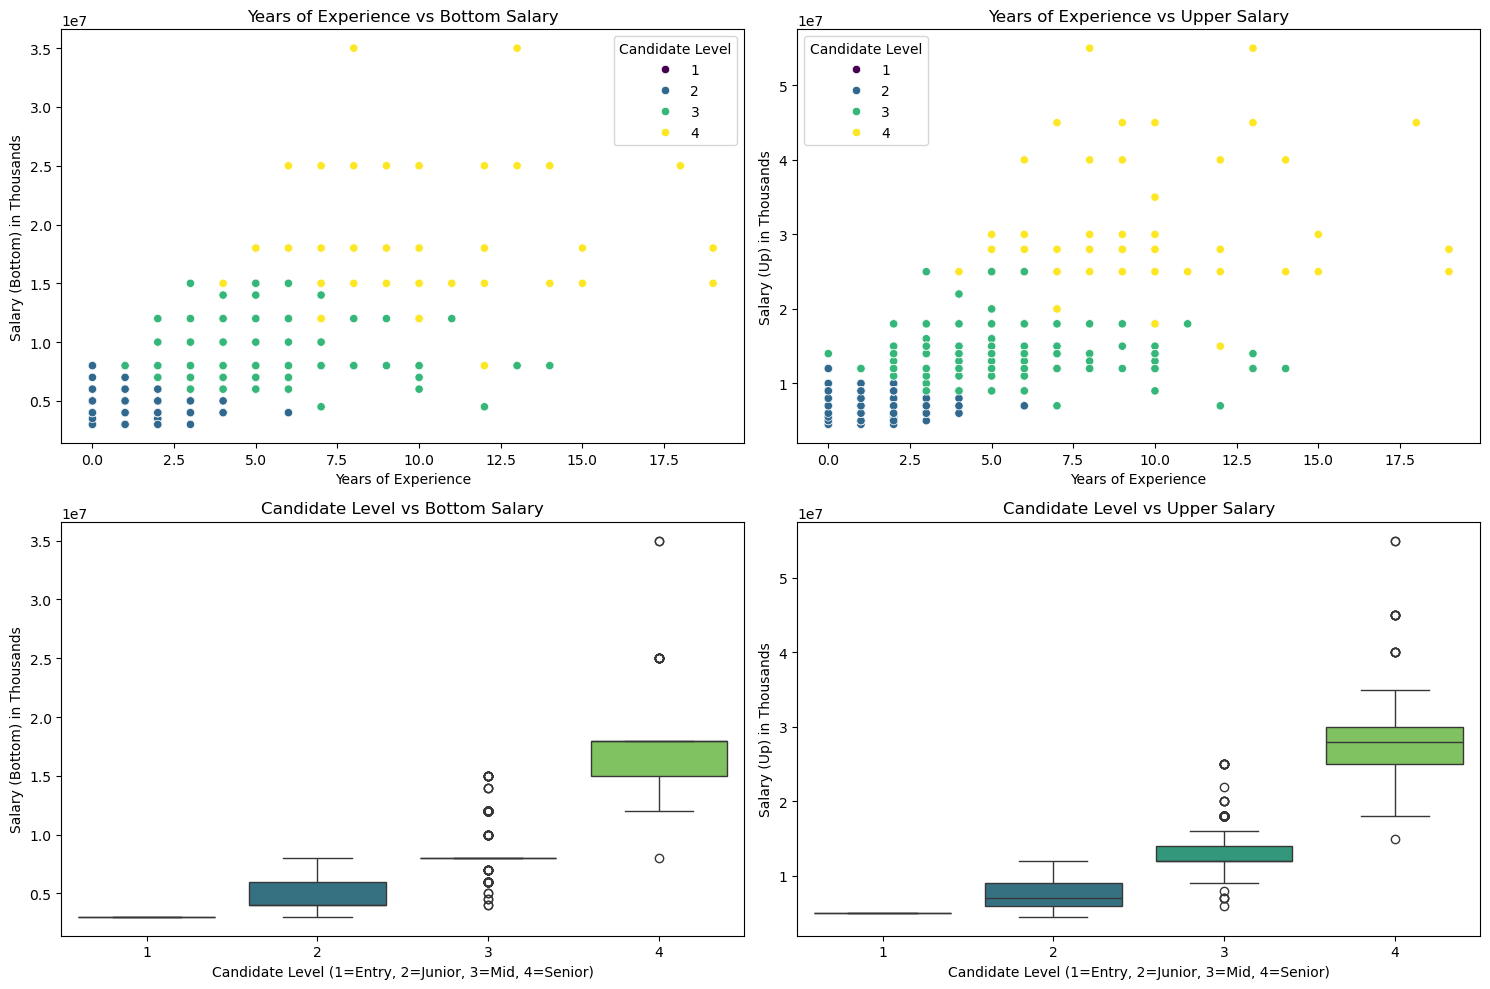


Average Salaries by Level:
                 Estimate Bottom   Estimate Up
Candidate Level                               
1                   3.000000e+06  5.000000e+06
2                   4.782051e+06  7.451049e+06
3                   8.573620e+06  1.318405e+07
4                   1.863333e+07  3.051667e+07


In [48]:
plt.figure(figsize=(15, 10))

# Top plots - Experience vs actual salary values
plt.subplot(2,2,1)
sns.scatterplot(data=train, x='Total Working Experience', y='Estimate Bottom', 
                hue='Candidate Level', palette='viridis')
plt.title('Years of Experience vs Bottom Salary')
plt.xlabel('Years of Experience')
plt.ylabel('Salary (Bottom) in Thousands')

plt.subplot(2,2,2)
sns.scatterplot(data=train, x='Total Working Experience', y='Estimate Up', 
                hue='Candidate Level', palette='viridis')
plt.title('Years of Experience vs Upper Salary')
plt.xlabel('Years of Experience')
plt.ylabel('Salary (Up) in Thousands')

# Bottom plots - Level vs actual salary values
plt.subplot(2,2,3)
sns.boxplot(data=train, x='Candidate Level', y='Estimate Bottom', palette='viridis')
plt.title('Candidate Level vs Bottom Salary')
plt.xlabel('Candidate Level (1=Entry, 2=Junior, 3=Mid, 4=Senior)')
plt.ylabel('Salary (Bottom) in Thousands')

plt.subplot(2,2,4)
sns.boxplot(data=train, x='Candidate Level', y='Estimate Up', palette='viridis')
plt.title('Candidate Level vs Upper Salary')
plt.xlabel('Candidate Level (1=Entry, 2=Junior, 3=Mid, 4=Senior)')
plt.ylabel('Salary (Up) in Thousands')

plt.tight_layout()
plt.show()

# Print average salaries by level for additional context
print("\nAverage Salaries by Level:")
avg_by_level = train.groupby('Candidate Level')[['Estimate Bottom', 'Estimate Up']].mean()
print(avg_by_level)